# Excerise 2: Analyzing decadal projection with observed weather at gridded level

##### Load all libraries

In [1]:
import xarray as xr
import glob
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import contextily as ctx

#### List input files

In [6]:
data_path = "C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\2023\\decadal_projections\\"
data_path_tif = "C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\2023\\decadal_projections\\tiff\\"
data_path1 = "C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\2023\\decadal_projections\\W5E5_v3"
out_maps = "C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\2023\\decadal_projections\\maps\\"
#shp_path = gpd.read_file("C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\CRA_4pagers_I\\DATA\\shp\\Kenya_country_level.shp")
#shp_path = gpd.read_file("C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\CRA_4pagers_I\\DATA\\shp\\Uganda_admin_level_1.shp")
shp_path = gpd.read_file("C:\\Users\\arumu002\\OneDrive - Wageningen University & Research\\Project CRAFT\\CRA_4pagers_I\\DATA\\shp\\Tanzania_admin_level_0.shp")
#variables = ['pr','tasmax','tasmin']
variables = 'pr'
mult_factor = 86400
buffer_degrees = 1
mam = [3, 4, 5]
sond = [9, 10, 11, 12]

##### List all netcdf files

In [7]:
################################################################
######### List files current and decadal projections ###############
################################################################
nc_files_cur = glob.glob(data_path1 + '\\' + variables + '*.nc')
folder = data_path + variables
nc_files = glob.glob(folder + '\\*.nc')

##### Merge and clip preciptattion data (Current) and selecting years for the current

In [8]:
##########################################################################################################################
######### Merge and clip preciptattion data (Current and Future) and selecting years for the current #######################
######################################## CURRENT ##########################################################
merged_data_cur = xr.open_mfdataset(nc_files_cur, concat_dim='time', combine='nested')
variable_to_extract_cur = merged_data_cur['pr'] * mult_factor
# Define the start and end years of the time range
start_year = 2009
end_year = 2019
# Create a time range filter using the .sel method
extract_years = variable_to_extract_cur.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
ds_cur = extract_years.rio.set_crs("EPSG:4326", inplace=True)
shp_path1 = shp_path.buffer(buffer_degrees)
clipped_data_cur1 = ds_cur.rio.clip(shp_path1.geometry)
new_lon_cur = np.arange(clipped_data_cur1.lon.min(), clipped_data_cur1.lon.max(), 1 / 50)  # 1 km resolution
new_lat_cur = np.arange(clipped_data_cur1.lat.min(), clipped_data_cur1.lat.max(), 1 / 50)  # 1 km resolution
# Interpolate the data to the new grid
interpolated_data_cur1 = ds_cur.interp(lon=new_lon_cur, lat=new_lat_cur, method='linear')
interpolated_data_cur = interpolated_data_cur1.rio.set_crs('EPSG:4326')
clipped_data_cur = interpolated_data_cur.rio.clip(shp_path.geometry)


C:\Users\arumu002\AppData\Local\Temp\ipykernel_31032\1511207729.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_path1 = shp_path.buffer(buffer_degrees)


##### Merge and clip preciptattion data (Future) and selecting years for the current

In [9]:
######################################## FUTURE ##########################################################
merged_data = xr.open_mfdataset(nc_files, concat_dim='time', combine='nested')
variable_to_extract = merged_data['pr'] * mult_factor
ds = variable_to_extract.rio.set_crs("EPSG:4326", inplace=True)
shp_path1 = shp_path.buffer(buffer_degrees + 1)
clipped_data1 = ds.rio.clip(shp_path1.geometry)
# Define the new grid with 1 km resolution (adjust the range according to your needs)
new_lon = np.arange(clipped_data1.lon.min(), clipped_data1.lon.max(), 1 / 50)  # 1 km resolution
new_lat = np.arange(clipped_data1.lat.min(), clipped_data1.lat.max(), 1 / 50)  # 1 km resolution
# Interpolate the data to the new grid
interpolated_data1 = clipped_data1.interp(lon=new_lon, lat=new_lat, method='linear')
interpolated_data = interpolated_data1.rio.set_crs('EPSG:4326')
clipped_data = interpolated_data.rio.clip(shp_path.geometry)

C:\Users\arumu002\AppData\Local\Temp\ipykernel_31032\3823904071.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_path1 = shp_path.buffer(buffer_degrees + 1)


#### Calculate seasonal rainfall (Current)

In [10]:
################ SEASONAL Rainfall Current ################################
########################## MAM ###########################################
filtered_data_mam_cur = clipped_data_cur.where(clipped_data_cur['time.month'].isin(mam), drop=True)
monthly_sum_mam_cur = filtered_data_mam_cur.resample(time='Y', skipna=True).sum()
decade_future_mam_cur = monthly_sum_mam_cur.mean(dim='time')
########################### SOND #########################################
filtered_data_sond_cur = clipped_data_cur.where(clipped_data_cur['time.month'].isin(sond), drop=True)
monthly_sum_sond_cur = filtered_data_sond_cur.resample(time='Y', skipna=True).sum()
decade_future_sond_cur = monthly_sum_sond_cur.mean(dim='time')

#### Calculate seasonal rainfall (Future)

In [11]:
########## SEASONAL Rainfall Future ################################
################### MAM ##########################
filtered_data_mam = clipped_data.where(clipped_data['time.month'].isin(mam), drop=True)
monthly_sum_mam = filtered_data_mam.resample(time='Y', skipna=True).sum()
decade_future_mam = monthly_sum_mam.mean(dim='time')
################### SOND #############################
filtered_data_sond = clipped_data.where(clipped_data['time.month'].isin(sond), drop=True)
monthly_sum_sond = filtered_data_sond.resample(time='Y', skipna=True).sum()
decade_future_sond = monthly_sum_sond.mean(dim='time')

#### Decide legend values according to the inputs

In [12]:
mam_seasonal_rf = xr.concat([decade_future_mam_cur, decade_future_mam], dim='time1')
max_value = mam_seasonal_rf.max(skipna=True).values
rounded_value_max = math.ceil(max_value / 100) * 100

#### Plot the maps

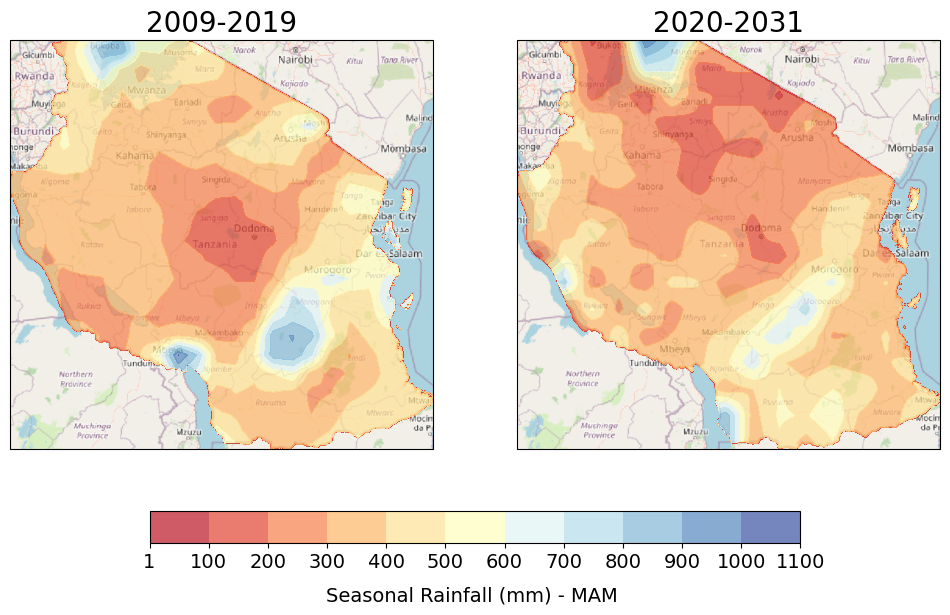

<Figure size 640x480 with 0 Axes>

In [13]:
#############################################################################################################
#############################################################################################################
# Create a single figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 10),subplot_kw={'projection': ccrs.PlateCarree()})

# Add a common basemap to both subplots using an image source (e.g., Stamen Terrain)
tiler = cimgt.OSM()
for ax in axes:
    ax.add_image(tiler, 6)  # 5 = zoom level

# categories = [100, 200, 300,400, 500,600,700,800,900,1000]
categories = [1, 100]
categories1 = list(range(200, rounded_value_max + 1, 100))  # Update with your specific categories
categories.extend(categories1)

# Plot the original data in the first subplot with a common legend
im1 = axes[0].contourf(decade_future_mam_cur['lon'], decade_future_mam_cur['lat'], decade_future_mam_cur,
                       levels=categories, cmap='RdYlBu',alpha=0.7)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('2009-2019',fontsize=20)

# Plot the smoothed data in the second subplot
im2 = axes[1].contourf(decade_future_mam['lon'], decade_future_mam['lat'], decade_future_mam, levels=categories,
                       cmap='RdYlBu',alpha=0.7)
axes[1].set_xlabel('Longitude',alpha=0.7)
axes[1].set_ylabel('Latitude')
axes[1].set_title('2020-2031',fontsize=20)

cbar = fig.colorbar(im1, ax=axes, ticks=categories, orientation='horizontal', pad=0.08,shrink=0.7)
cbar.set_label('Seasonal Rainfall (mm) - MAM ', labelpad=10, fontsize=14)  # Set the label and adjust label padding
cbar.ax.tick_params(labelsize=14)  # Adjust the font size as needed
cbar.set_ticks(categories)
cbar.set_ticklabels(categories)
plt.show()
plt.savefig(out_maps+"Seasonal_Rainfall_MAM_Tanzania.png", dpi=500, bbox_inches="tight")
